In [1]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot
from tyssue.solvers import QSSolver

from IPython.display import Image


from tyssue.topology import add_vert

import tyssue.dynamics as tydyn
from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

collision solver could not be imported You may need to install CGAL and re-install tyssue
C++ extension are not available for this version


In [2]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [3]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [4]:
def change_specs(cellmap, geom, model, history, face_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought, endTime):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)

    
    cellmap.face_df["face_elasticity"] = face_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1   
    
    #cellmap_original.face_df["prefered_area"][0] = 2
    #cellmap_original.face_df["prefered_area"][41] = 2
    
    solver1 = EulerSolver(cellmap, geom, model, history=history, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver1.eptm,))
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

In [5]:
def create_frames(
    history,
    output,
    movie_name,
    num_frames=None,
    interval=None,
    draw_func=None,
    margin=5,
    **draw_kwds,
):
    """Creates a set of png frames of the recorded history.
   
    Parameters
    ----------
    history : a :class:`tyssue.History` object
    output : path to the output directory
    num_frames : int, the number of frames in the gif
    interval : tuples, define begin and end frame of the gif
    draw_func : a drawing function
         this function must take a `sheet` object as first argument
         and return a `fig, ax` pair. Defaults to quick_edge_draw
         (aka sheet_view with quick mode)
    margin : int, the graph margins in percents, default 5
         if margin is -1, let the draw function decide
    **draw_kwds are passed to the drawing function
    """
    if draw_func is None:
        draw_func = sheet_view

    graph_dir = Path(output + '/' + movie_name)
    graph_dir.mkdir(parents=True, exist_ok=True)

    x, y = coords = draw_kwds.get("coords", history.sheet.coords[:2])
    sheet0 = history.retrieve(0)
    bounds = sheet0.vert_df[coords].describe().loc[["min", "max"]]
    delta = (bounds.loc["max"] - bounds.loc["min"]).max()
    margin = delta * margin / 100
    xlim = bounds.loc["min", x] - margin, bounds.loc["max", x] + margin
    ylim = bounds.loc["min", y] - margin, bounds.loc["max", y] + margin

    if interval is None:
        start, stop = None, None
    else:
        start, stop = interval[0], interval[1]

    for i, (t, sheet) in enumerate(history.browse(start, stop, num_frames)):
        try:
            fig, ax = draw_func(sheet, **draw_kwds)
        except Exception as e:
            print("Droped frame {i}")

        if isinstance(ax, plt.Axes) and margin >= 0:
            ax.set(xlim=xlim, ylim=ylim)
        fig.savefig(graph_dir / f"movie_{i:04d}.png")
        plt.close(fig)

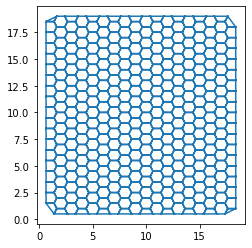

In [6]:
## Definition of the sheet
geom_original  = SheetGeometry
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

cellmap_original = Sheet.planar_sheet_3d('cellmap', 20, 20, 1, 1) # This may need to change

cellmap_original.vert_df["viscosity"] = 1 

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

In [ ]:
prefered_area_values = np.linspace(1, 10, 20)
prefered_area_values

In [ ]:
for prefered_area in prefered_area_values:
    print(prefered_area)

In [ ]:
cellmap_original.face_df['prefered_area'] = 1
cellmap_original.edge_df['length_elasticity'] = 0.1
geom.update_all(cellmap_original)
cellmap_original.update_specs(model_original.specs)
solver = EulerSolver(cellmap_original, geom_original, model_original, auto_reconnect=True)
res = solver.solve(tf=10, dt=10)
parameter_of_interest = cellmap_original.face_df['area'].mean()
print(parameter_of_interest)



#geom.update_all(cellmap_original)
#cellmap_original.update_specs(model_original.specs)

#fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')
#solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
#res1 = solver1.solve(tf=10, dt=0.05)



#cellmap_original.face_df['area']

In [13]:
# Define the parameter space to explore

def phase_diagram( x, y, z, h, n_vals):
    
    cellmap_original = Sheet.planar_sheet_3d('cellmap', 20, 20, 1, 1)
    cellmap_original.vert_df["viscosity"] = 1   

    
    #define ranges of investigated parameters
    
    prefered_area_values = np.linspace(x, y, n_vals)
    length_elasticity_values = np.linspace(z, h, n_vals)

    # Simulate the tyssue model for each parameter set
    
    parameter_of_interest_values = np.zeros((n_vals, n_vals))
    
    for i in prefered_area_values:
        print(i)
        cellmap = cellmap_original
        for j in length_elasticity_values:
            print(j)
            cellmap.face_df['prefered_area'] = i
            cellmap.edge_df['length_elasticity'] = j
            geom.update_all(cellmap)
            cellmap.update_specs(model.specs)
            solver = EulerSolver(cellmap, geom, model, auto_reconnect=True)
            res = solver.solve(tf=10, dt=10)
            parameter_of_interest = cellmap.face_df['area'].mean()
            print(parameter_of_interest)
            
            
    # Visualize the phase diagram
    fig, ax = plt.subplots()
    im = ax.imshow(parameter_of_interest, cmap='coolwarm',
                   extent=[prefered_area_values.min(), prefered_area_values.max(), length_elasticity_values.min(), length_elasticity_values.max()],
                   aspect='auto')
    ax.set_xlabel('Prefered area')
    ax.set_ylabel('Length elasticity')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Area')
    plt.show()
    

In [14]:
phase_diagram(1, 10, 0.1, 2, 20)


1.0
0.1
0.0
0.2
0.0
0.3
0.0
0.4
0.0
0.5
0.0
0.6
0.0
0.7
0.0
0.7999999999999999
0.0
0.8999999999999999
0.0
0.9999999999999999
0.0
1.0999999999999999
0.0
1.2
0.0
1.3
0.0
1.4
0.0
1.5
0.0
1.5999999999999999
0.0
1.7
0.0
1.8
0.0
1.9
0.0
2.0
0.0
1.4736842105263157
0.1
0.0
0.2
0.0
0.3
0.0
0.4
0.0
0.5
0.0
0.6
0.0
0.7
0.0
0.7999999999999999
0.0
0.8999999999999999
0.0
0.9999999999999999
0.0
1.0999999999999999
0.0
1.2
0.0
1.3
0.0
1.4
0.0
1.5
0.0
1.5999999999999999
0.0
1.7
0.0
1.8


KeyboardInterrupt: 

In [ ]:

# Define the parameter space to explore

n_vals = 10
J_vals = np.linspace(0.1, 1.0, n_vals)
K_vals = np.linspace(0.1, 1.0, n_vals)


# Define the order parameter

order_parameter = sheet.area_perimeter_ratios(cell_type='columnar')
# Simulate the tissue model for each parameter set
order_parameter_values = np.zeros((n_vals, n_vals))
for i, J in enumerate(J_vals):
    for j, K in enumerate(K_vals):
        sheet.settings['J'], sheet.settings['K'] = J, K
        ty.converge.sheet_vertex_model(sheet, params=['J', 'K'])
        order_parameter_values[i, j] = order_parameter.mean()
# Visualize the phase diagram
fig, ax = plt.subplots()
im = ax.imshow(order_parameter_values, cmap='coolwarm',
               extent=[K_vals.min(), K_vals.max(), J_vals.min(), J_vals.max()],
               aspect='auto')
ax.set_xlabel('K')
ax.set_ylabel('J')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Order Parameter')
plt.show()